# Calculate Run Value from Pitch by Pitch Data

## Purpose:
### Prepare model to apply to synergy data to create similar matrix to the college baseball run environment, more specifically the CAA.

## Deriving run values from pitch by pitch data from the 2022 regular season:
### 1. Create a column containing the count-out-base state for each pitch.
### 2. Split the data into individual half-innings.
### 3. For each half-inning, create a new column that holds the difference in runs scored by the end of the half-inning compared to the beginning.
### 4. Iterate through each pitch, adding the value in the 'runs_by_end' column to the existing run value for that state and increasing the count of times that state has occurred in a dictionary of states and run values. If the state is not already in the dictionary, add it with the value of 'runs_by_end' and a count of 1.
### 5. For each state in the dictionary, divide the total run value by the number of times that state occurred to calculate the average runs scored by the end of the half-inning when that state is present.
### 6. Create a new dictionary with the states as keys and the average runs scored as values.

In [1]:
import pybaseball as pyb
import pandas as pd
from collections import defaultdict
import numpy as np
import os
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
import time
import itertools

In [2]:
def inning_game_ids(pxp):
    """
    Categorize plays based on game names and innings
    
    pxp: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of categorized plays with game_id and inning_id columns
    """
    plays = []
    game_id = 0
    inning_id = 0
    game = None
    inning = None
    
    for play in pxp.to_dict('records'):
        current_game = play.get('Notes')
        current_inning = play.get('Inning')
        
        if current_game != game:
            game_id += 1
            inning_id += 1
            game = current_game
            inning = current_inning
        elif current_inning != inning:
            inning_id += 1
            inning = current_inning
        
        play['game_id'] = game_id
        play['inning_id'] = inning_id
        plays.append(play)
    
    return pd.DataFrame(plays)

def base_count_score(pxp):
    """
    Process play-by-play data by splitting scores, counts, and runners on base
    
    pxp: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of processed play-by-play data with added columns for bat_score, 
        balls, strikes, on_1b, on_2b, and on_3b
    """
    data = pxp.to_dict('records')
    
    for play in data:
        score = play['Score'].split('-')
        if play['Inning'][0] == 'T':
            play['bat_score'] = int(score[0])
        else:
            play['bat_score'] = int(score[1])
        
        count = play['Count'].split('-')
        play['balls'] = count[0]
        play['strikes'] = count[1]
        
        play['on_1b'] = 1 if '1B' in play['Runners On Base'] else 0
        play['on_2b'] = 1 if '2B' in play['Runners On Base'] else 0
        play['on_3b'] = 1 if '3B' in play['Runners On Base'] else 0
    
    return pd.DataFrame(data)


def seperate_bunts(row):
    '''
    If the BIP Type is a bunt, make that the event as opposed to 'Single' or 'Groundout'
    '''
    if row['BIP Type'] in bunts:
        row['event'] = row['BIP Type']
    return row

def add_lineup_number(df):
    '''
    Process play-by-play data to add lineup number
    
    df: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of processed play-by-play data with added column for lineup number
    '''
    data = df.to_dict('records')
    
    current_game = None
    current_batter = None
    lineup_number = 0
    
    for play in data:
        if current_game != play['gameId']:
            current_game = play['gameId']
            current_batter = play['batterId']
            lineup_number = 1
            
        if current_batter != play['batterId']:
            current_batter = play['batterId']
            if lineup_number == 9:
                lineup_number = 1
            else:
                lineup_number += 1
            
        play['lineup_number'] = lineup_number
        
    return pd.DataFrame(data)

def event_run(event,pxp):
    event_run = pxp.loc[pxp['event'].isin(event)]
    event_run = event_run[['state','run_scored_by_end?']].groupby(['state']).mean()
    return event_run

def event_rv(event):
    event_rv = pxp_updated.loc[pxp_updated['event'].isin(event)]
    event_rv = event_rv['delta_run_expectancy'].mean()
    return event_rv


def count_plate_appearances(df):
    '''
    Count plate appearances
    
    df: DataFrame
        DataFrame of play by play data
        
    Returns:
        Dictionary of plate appearances by game and lineup number
    '''
    plate_appearances = {}
    data = df.to_dict('records')
    current_game = None
    current_hitter = None
    
    for play in data:
        if current_game != play["gameId"]:
            current_game = play["gameId"]
            plate_appearances[current_game] = {}
            current_hitter = None
        lineup_number = play["lineup_number"]
        if lineup_number not in plate_appearances[current_game]:
            plate_appearances[current_game][lineup_number] = 0
        if current_hitter != play["batterId"]:
            current_hitter = play["batterId"]
            plate_appearances[current_game][lineup_number] += 1
    
    return plate_appearances

def average_plate_appearance(dictionary):
    result = defaultdict(list)
    for game in dictionary.values():
        for lineup, plate_appearance in game.items():
            result[lineup].append(plate_appearance)
    return {key: sum(value)/len(value) for key, value in result.items()}

def count_plate_appearances_by_outs(df):
    '''
    Count plate appearances by outs
    
    df: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of plate appearances by outs, sorted by lineup number
    '''
    plate_appearances = {0: {}, 1: {}, 2: {}}
    data = df.to_dict('records')
    current_game = None
    current_hitter = None
    
    for play in data:
        if current_game != play["gameId"]:
            current_game = play["gameId"]
        lineup_number = play["lineup_number"]
        outs = play["Outs"]
        if outs in plate_appearances and lineup_number not in plate_appearances[outs]:
            plate_appearances[outs][lineup_number] = 0
        if outs in plate_appearances and current_hitter != play["batterId"]:
            plate_appearances[outs][lineup_number] += 1
            current_hitter = play["batterId"]
    
    df = pd.DataFrame.from_dict(plate_appearances)
    res = df.div(df.sum(axis=1), axis=0)

    return res.sort_index()


def rob_df(df):
    df['runners_on'] = df['on_1b'] + df['on_2b'] + df['on_3b']
    df['runner_on'] = df['runners_on'] >= 1
    df['runner_on'] = df['runner_on'].astype(int)
    df_grouped = df.groupby('lineup_number').agg({'runner_on': 'sum','runners_on': 'sum'})
    df_grouped['PA empty'] = df.groupby('lineup_number').size() - df_grouped['runner_on']
    df_grouped['PA men on'] = df_grouped['runner_on']
    df_grouped['Men on per PA'] = df_grouped['runners_on']
    df_grouped['% PA with men on'] = round(df_grouped['PA men on'] / df.groupby('lineup_number').size(),3)
    df_grouped['Men on per PA'] = round(df_grouped['Men on per PA'] / (df_grouped['PA men on'] + df_grouped[
        'PA empty']),3)
    df_grouped['# of runners on per PA'] = df_grouped['PA men on'] / df_grouped['PA men on'].sum()
    df_grouped = df_grouped.reset_index()
    df_grouped.set_index('lineup_number', inplace=True)
    
    return df_grouped


In [3]:
# simplfies events to shorthand
simple_results = {
    'Double' : '2B',
    'Field Error' : 'RBOE',
    "Fielder's Choice - Out" : 'GO',
    "Fielder's Choice - Safe'" : 'GO',
    'Fly Ball Into Double Play' : 'FO',
    'Flyout' : 'FO',
    'Ground Rule Double' : '2B',
    'Grounded Into Double Play' : 'GO',
    'Groundout' : 'GO',
    'Home Run' : 'HR',
    'Home Run Inside The Park' : 'HR',
    'Infield Fly Rule' : 'IFB',
    'Lined Into Double Play' : 'LO',
    'Lined Into Triple Play' : 'LO',
    'Lineout' : 'LO',
    'Popout' : 'FO',
    'Popped Into Double Play' : 'FO',
    'Sacrifice Bunt' : 'Bunt',
    'Sacrifice Fly' : 'FO',
    'Single' : '1B',
    'Triple' : '3B',
    'Strikeout' : 'K',
    'Walk' : 'BB',
    'Hit By Pitch': 'HBP',
    'Intentional Walk' : 'IBB',
    'Ground Out' : 'GO',
    'Strikeout (Swinging)' : 'K',
    'Pop Out' : 'FO',
    'Single' : '1B',
    "Fielder's Choice" : 'GO',
    'Strikeout (Looking)' : 'K',
    'Walk':'BB',
    'Double': '2B',
    'Sac Bunt':'Bunt',
    'Fly Out' : 'FO',
    'Hit By Pitch':'HBP',
    'Triple' :'3B',
    'Home Run' : 'HR',
    'Line Out' : 'LO',
    "Reached on Fielder's Choice" : 'GO',
    'Reached on Error on a Ground Ball': 'GO',
    'Sac Fly' : 'FO',
    'Bunt Ground Out' : 'Bunt',
    'Bunt Pop Out' : 'Bunt',
    'Reached on Error on a Bunt Ground Ball' : 'Bunt',
    'Reached on Error on a Fly Ball' : 'FO',
    'Intentional Walk' : 'IBB',
    'Reached on Error on a Pop Up' : 'FO',
    'Batter Interference' : 'B-Int',
    'Catcher Interference' : 'C-Int',
    'Reached on Error on a Line Drive' : 'LO',
    'Reached on Error' : 'RBOE',
    'In-the-park Home Run on a Fly Ball': 'HR',
    'Bunt' : 'Bunt'
}

# groups all balls and strikes together
count_result = {
    'Ball' : 'B',
    'Strike Taken' : 'S',
    'Strike Swinging' : 'S',
    'Strikeout' : 'S',
    'Ball' : 'B'
}

woba_results = {
    'BB':'BB',
    'HBP':'HPB',
    '1B':'1B',
    '2B':'2B',
    '3B':'3B',
    'HR':'HR',
    'K':'Out',
    'BIP - Out':'Out',
    'BIP - Out':'Out',
    'BIP - Out':'Out',
}

non_result_event = {
    'Ball' : 'Ball',
    'Strike Looking' : 'Strike Looking',
    'Strike Swinging' : 'Strike Swinging',
    'Foul' : 'Foul'
}

In [4]:
# Read all the csv files in folder
folder = 'tru media exports'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
# Combine the dataframes into one
tm = pd.concat(dataframes, axis=0)

In [5]:
tm['event'] = tm['pitchResult'].fillna('')

tm.loc[tm['event'].str.startswith('Home Run', na=False), 'event'] = 'Home Run'

tm.loc[tm['event'].str.contains('Single', case=False) & ~tm['event'].str.contains(
    'Bunt', case=False), 'event'] = 'Single'

tm.loc[tm['event'].str.contains('Double', case=False) & ~tm['event'].str.contains(
    'Bunt', case=False) & ~tm['event'].str.contains(
    'Double Play', case=False), 'event'] = 'Double'

tm.loc[tm['event'].str.contains('Triple', case=False) & ~tm['event'].str.contains(
    'Bunt', case=False) & ~tm['event'].str.contains(
    'Triple Play', case=False), 'event'] = 'Triple'

tm.loc[tm['event'].str.contains('Bunt', case=False), 'event'] = 'Bunt'

tm['inning_id'] = (tm['gameId'].astype(str) + tm['inn'].astype(str))
tm['ManOn1st'] = tm['ManOn1st'].fillna(0).astype(int)
tm['ManOn2nd'] = tm['ManOn2nd'].fillna(0).astype(int)
tm['ManOn3rd'] = tm['ManOn3rd'].fillna(0).astype(int)
tm.rename(columns={'outs' : 'Outs', 'ManOn1st' : 'on_1b', 'ManOn2nd' : 'on_2b',
                   'ManOn3rd' : 'on_3b', 'currentRuns' : 'bat_score'},inplace =True)

tm[['Balls','Strikes']] = tm['count'].str.split('-', expand=True).astype(int)

tm = tm.loc[tm['Balls'] < 4]
tm = tm.loc[tm['Strikes'] < 3]

# saves inning as int
tm['inning'] = tm['inn'].astype(str).str[-2:].astype(int)

tm = add_lineup_number(tm)

outs_at_lineup = count_plate_appearances_by_outs(tm)

plate_appearances = count_plate_appearances(tm)

bot_innings = tm[tm['inn'].str.startswith('Bot')].groupby('gameId')

indices_to_drop = [game_df.index.max() for game_id, game_df in bot_innings]
pxp = tm.drop(indices_to_drop)

In [6]:
# Some rows are tagged with -1 or 3 outs
pxp = pxp.loc[pxp['Outs'] >= 0]
pxp = pxp.loc[pxp['Outs'] < 3]

# Create a game state column
pxp['state'] = (
    pxp['Balls'].astype(str) + 
    pxp['Strikes'].astype(str) +
    pxp['Outs'].astype(str) + 
    pxp['on_1b'].astype(str) + 
    pxp['on_2b'].astype(str) + 
    pxp['on_3b'].astype(str)
)

pxp['out_base_state'] = pxp['state'].apply(lambda x: x[2:])

# Calculate runs scored by end of each inning from the current state
runs_by_end = pxp.groupby('inning_id')['bat_score'].max()
pxp['runs_at_end'] = pxp['inning_id'].map(runs_by_end)
pxp['runs_by_end'] = pxp['runs_at_end'] - pxp['bat_score']

# Calculate the run expectancy with count in mind
count_state_run_expectancy = pxp.groupby('state')['runs_by_end'].mean()
pxp['count_run_expectancy'] = pxp['state'].map(count_state_run_expectancy)

# Calculate the run expectancy for each base out state
out_state_run_expectancy = pxp.groupby('out_base_state')['runs_by_end'].mean()
pxp['result_run_expectancy'] = pxp['out_base_state'].map(out_state_run_expectancy)

# Add run scored 
pxp['runs_scored'] = pxp['bat_score'].shift(-1) - pxp['bat_score']
inning_match = pxp['inning_id'].eq(pxp['inning_id'].shift(-1))
pxp['runs_scored'] = pxp['runs_scored'].where(inning_match, 0)

next_re = pxp['result_run_expectancy'].shift(-1)
mask = pxp['inning_id'] == pxp['inning_id'].shift(-1)
pxp['delta_result_run_expectancy'] = np.where(mask, next_re - pxp['result_run_expectancy'] + pxp['runs_scored'],
                                       -pxp['result_run_expectancy'] + pxp['runs_scored'])

next_re = pxp['result_run_expectancy'].shift(-1)
mask = pxp['inning_id'] == pxp['inning_id'].shift(-1)
pxp['delta_count_run_expectancy'] = np.where(mask, next_re - pxp['result_run_expectancy'] + pxp['runs_scored'],
                                       -pxp['result_run_expectancy'] + pxp['runs_scored'])


# Normalize average run value to 0
pxp[['result_run_value']] = pxp[['delta_result_run_expectancy']] + pxp[['delta_result_run_expectancy']].mean(
    ) * -1

pxp[['count_run_value']] = pxp[['delta_count_run_expectancy']] + pxp[['delta_count_run_expectancy']].mean() * -1


# At least 1 run scored by the end of the inning?
pxp['run_scored_by_end?'] = [1 if x > 0 else 0 for x in pxp['runs_by_end']]

pxp.reset_index(inplace = True)

# Classify result pitches
pxp['simple_results'] = pxp.event.map(simple_results)
pxp['simple_event'] = pxp.event.map({**simple_results,**non_result_event})
pxp['woba_results'] = pxp['simple_results'].map(woba_results)

simple_result_run_value = pxp[['result_run_value','simple_results']].groupby('simple_results').mean()[
    'result_run_value']
pxp['xrRV'] = pxp['simple_results'].map(simple_result_run_value)

simple_count_run_value = pxp[['count_run_value','simple_event']].groupby('simple_event').mean()[
    'count_run_value']
pxp['xRV'] = pxp['simple_event'].map(simple_count_run_value)

pxp = pxp.loc[~pxp['inning_id'].isin(list(pxp.dropna(subset='simple_results').loc[
    pxp.dropna(subset='simple_results')['delta_result_run_expectancy']== 0]['inning_id'].unique()))]

In [7]:
grouped = pxp.groupby('pitchTypeFull').agg({'count_run_value': 'mean', 'xRV': 'mean', 'count': 'size'})
result = grouped[grouped['count'] >= 250][['count_run_value','xRV']].sort_values(
    'count_run_value', ascending=False)
result['RV/100'] = result['count_run_value'] * 100
result['xRV/100'] = result['xRV'] * 100
result['Percent Change'] = 100*(result['RV/100'] - result['xRV/100'])/result['RV/100']
display(result[['RV/100','xRV/100','Percent Change']])

,RV/100,xRV/100,Percent Change
pitchTypeFull,,,
Fastball,0.733836,1.337456,-82.255361
Cutter,-0.024558,-0.034625,-40.995023
Changeup,-1.121503,-0.691149,38.373005
Curveball,-1.239674,-1.064680,14.116125
Slider,-1.716277,-1.358687,20.835200


Here we can see the realized run value of each pitch type compared to the expected run value, or context blind run value. Interesting to not that fastballs have a large difference in xRV and RV. While I have yet to look into what these numbers mean, it has a lot of potential.

In [8]:
# Calculate runs scored by end of each inning from the current state
runs_by_end = pxp.groupby('inning_id')['bat_score'].max()
pxp['runs_at_end'] = pxp['inning_id'].map(runs_by_end)
pxp['runs_by_end'] = pxp['runs_at_end'] - pxp['bat_score']

# Calculate the run expectancy for each state
state_run_expectancy = pxp.groupby('out_base_state')['runs_by_end'].mean()

pxp['run_expectancy'] = pxp['out_base_state'].map(state_run_expectancy)

## Build Base State Run Expectancy Matrix

In [9]:
state_matrix = pd.DataFrame(list(state_run_expectancy.items()), columns=['keys', 'values'])
state_matrix['Outs'] = state_matrix["keys"].apply(lambda x: x[0])
state_matrix['Runners'] = state_matrix["keys"].apply(lambda x: x[1:])
state_matrix = state_matrix.pivot(index='Runners', columns='Outs', values='values')
display(state_matrix)

Outs,0,1,2
Runners,,,
000,0.667331,0.347549,0.124008
001,1.664394,1.058862,0.429782
010,1.352018,0.809796,0.365123
011,2.282532,1.564017,0.642935
100,1.150821,0.671867,0.265971
101,2.072848,1.318333,0.506648
110,1.909672,1.157259,0.537780
111,2.747049,1.962766,1.010029


## Run Values by Event

In [10]:
display(pxp.groupby('simple_results').mean()['result_run_value'])

simple_results
1B       0.525025
2B       0.804136
3B       1.087715
B-Int   -0.447259
BB       0.392562
Bunt    -0.032943
C-Int    0.449394
FO      -0.343230
GO      -0.258169
HBP      0.415376
HR       1.443899
IBB      0.186649
K       -0.372808
LO      -0.339968
RBOE     0.627260
Name: result_run_value, dtype: float64

## Calculate linear model for xOPS and xOBP

In [11]:
# Read all the csv files in folder
folder = 'indy stats'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
# Combine the dataframes into one
stats = pd.concat(dataframes, axis=0).set_index('playerId')

In [12]:
# Calculate mean stats for each batter
hitters_mean = pxp.dropna(subset=['xRV']).groupby(
    ['batterId', 'fullName', 'batterAbbrevName']).filter(lambda x: len(x) >= 400).groupby(
    ['batterId', 'fullName', 'batterAbbrevName']).mean().reset_index().set_index('batterId')
# Add batting stats
hitters_mean = hitters_mean.merge(stats, left_index=True, right_index=True)
hitters_mean['OBP'] = hitters_mean['OBP'].astype(float)
hitters_mean['SLG'] = hitters_mean['SLG'].astype(float)
hitters_mean['OPS'] = hitters_mean['OBP'] + hitters_mean['SLG']

# Select the relevant features
X = hitters_mean[['xRV']]

# Select the target variables
y_obp = hitters_mean['OBP']
y_slg = hitters_mean['SLG']
y_ops = hitters_mean['OPS']

# Create a Linear Regression model for predicting OBP
model_obp = LinearRegression()
model_obp.fit(X, y_obp)

# Create a Linear Regression model for predicting SLG
model_slg = LinearRegression()
model_slg.fit(X, y_slg)

# Create a Linear Regression model for predicting OPS
model_ops = LinearRegression()
model_ops.fit(X, y_ops)

LinearRegression()

In [13]:
hitters_mean['xOPS'] = model_ops.predict(X)
hitters_mean['xOBP'] = model_obp.predict(X)
hitters_mean['xSLG'] = model_slg.predict(X)

In [14]:
display(r2_score(hitters_mean['SLG'], hitters_mean['xSLG']))
display(r2_score(hitters_mean['OBP'], hitters_mean['xOBP']))
display(r2_score(hitters_mean['OPS'], hitters_mean['xOPS']))

0.722401605699956

0.5734735576265535

0.7838684961001232

In [15]:
display(r2_score(hitters_mean['SLG'], hitters_mean['xSLG']))
display(r2_score(hitters_mean['OBP'], hitters_mean['xOBP']))
display(r2_score(hitters_mean['OPS'], hitters_mean['xOPS']))

0.722401605699956

0.5734735576265535

0.7838684961001232

In [16]:
display(hitters_mean[['OBP','OPS']].astype(float).mean())

OBP    0.369171
OPS    0.790155
dtype: float64

## Plot linearity of xrRV and OPS

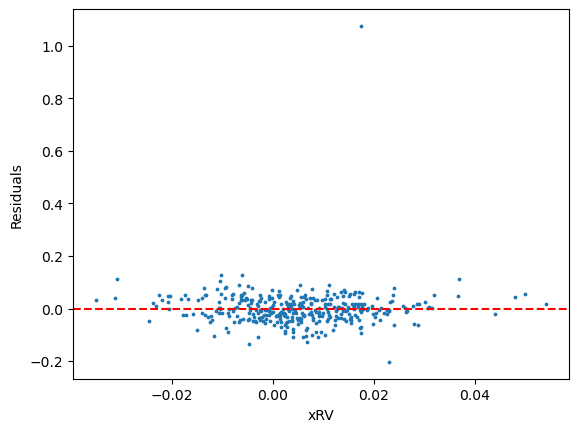

In [17]:
residuals = hitters_mean['OPS'] - hitters_mean['xOPS']

plt.scatter(X, residuals, 3)
plt.xlabel('xRV')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


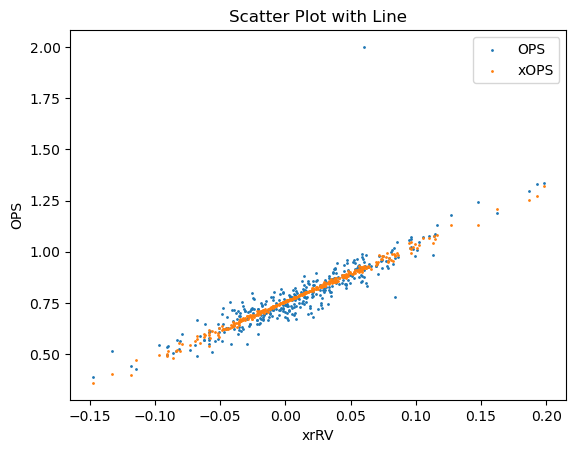

In [18]:
# Plot the line
plt.scatter(hitters_mean['xrRV'],hitters_mean['OPS'], 1, label = 'OPS')
plt.scatter(hitters_mean['xrRV'],hitters_mean['xOPS'], 1, label = 'xOPS')

# Add labels to the axes and title to the plot
plt.xlabel('xrRV')
plt.ylabel('OPS')
plt.title('Scatter Plot with Line')

# Show the plot
plt.legend()
plt.show()

## Bunting Analysis

In [19]:
bunt_pxp = pxp.loc[pxp['event'] == 'Bunt']
non_bunt_pxp = pxp.loc[pxp['event'] != 'Bunt']

bunt_pxp = bunt_pxp.groupby(['out_base_state']).agg({'result_run_value': 'mean','run_scored_by_end?': 'mean',
                                                     'out_base_state': 'size'})
bunt_pxp = bunt_pxp.rename(columns={'out_base_state': 'counts'})
bunt_pxp = bunt_pxp.sort_values(
    'run_scored_by_end?', ascending = False)

non_bunt_pxp = non_bunt_pxp.groupby(['out_base_state']).agg(
    {'run_scored_by_end?': 'mean', 'out_base_state': 'size'})
non_bunt_pxp = non_bunt_pxp.rename(columns={'out_base_state': 'counts'})
non_bunt_pxp = non_bunt_pxp.sort_values(
    'run_scored_by_end?', ascending = False)

In [20]:
bunt_pxp['percent_increased'] = round(100*(bunt_pxp['run_scored_by_end?'] - non_bunt_pxp['run_scored_by_end?']),2)

bunt_run_score_matrix = bunt_pxp.loc[bunt_pxp['counts'] > 10][['percent_increased','counts']].sort_index(
).reset_index()

bunt_run_score_matrix['Outs'] = bunt_run_score_matrix['out_base_state'].apply(lambda x: x[0])
bunt_run_score_matrix['Runners'] = bunt_run_score_matrix['out_base_state'].apply(lambda x: x[1:])
bunt_run_score_matrix = bunt_run_score_matrix.pivot(index='Runners', columns='Outs', values='percent_increased'
                                                   ).fillna('-')
display(bunt_run_score_matrix)

Outs,0,1,2
Runners,,,
000,3.85,-2.53,-0.33
001,-,20.89,10.29
010,9.52,15.72,-
011,-,21.41,-
100,-2.62,1.96,3.98
101,8.88,15.62,-
110,4.0,3.57,-


When the goal moves from maximizing runs to scoring at least one, ex: bottom half of extra innings, teams should  bunt with 1 out and runners at the corners, assuming the batter is not a sub-par bunter.

In [21]:
bunt_run_expectancy = bunt_pxp.loc[bunt_pxp['counts'] > 30][['result_run_value','counts']].sort_index(
).reset_index()

bunt_run_expectancy['Outs'] = bunt_run_expectancy['out_base_state'].apply(lambda x: x[0])
bunt_run_expectancy['Runners'] = bunt_run_expectancy['out_base_state'].apply(lambda x: x[1:])
bunt_run_expectancy_matrix = bunt_run_expectancy.pivot(
    index='Runners', columns='Outs', values='result_run_value').fillna('-')

X = bunt_run_expectancy[['result_run_value']]

bunt_run_expectancy['xOPS'] = model_ops.predict(X)
bunt_run_expectancy['xOPS'] = round(bunt_run_expectancy['xOPS'].clip(lower=0),3)


bunt_ops_threshold_matrix = bunt_run_expectancy.pivot(
    index='Runners', columns='Outs', values='xOPS').fillna('-')

display(bunt_run_expectancy_matrix)
display(bunt_ops_threshold_matrix)

/Users/reececalvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- result_run_value
Feature names seen at fit time, yet now missing:
- xRV

  warnings.warn(message, FutureWarning)


Outs,0,1,2
Runners,,,
000,0.037743,-0.047487,-0.053259
010,0.008930,0.101831,-
100,-0.112284,-0.044791,0.061209
101,0.051643,0.124442,-
110,-0.093649,0.338629,-


Outs,0,1,2
Runners,,,
000,1.142,0.228,0.166
010,0.833,1.829,-
100,0.000,0.257,1.393
101,1.291,2.071,-
110,0.000,4.367,-


These tables show the average run value for a bunt in each state. The second chart are xOPS thresholds and in theory, if a batter is below a given OPS, they should bunt. Assuming they are an average bunter.

In [22]:
bunt_ops_matrix = bunt_pxp[['result_run_value','counts']].sort_index().reset_index()

X = bunt_ops_matrix[['result_run_value']]


bunt_ops_matrix['xOPS'] = model_ops.predict(X)

bunt_ops_matrix['Outs'] = bunt_ops_matrix['out_base_state'].apply(lambda x: x[0])
bunt_ops_matrix['Runners'] = bunt_ops_matrix['out_base_state'].apply(lambda x: x[1:])
bunt_ops_matrix = bunt_ops_matrix.pivot(
    index='Runners', columns='Outs', values='xOPS').fillna('-')
display(bunt_ops_matrix)

/Users/reececalvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- result_run_value
Feature names seen at fit time, yet now missing:
- xRV

  warnings.warn(message, FutureWarning)


Outs,0,1,2
Runners,,,
000,1.141743,0.228032,0.166158
001,-4.887388,3.172149,1.471550
010,0.832847,1.828791,-0.179936
011,1.033362,3.788749,5.989355
100,-0.466614,0.256938,1.393311
101,1.290755,2.071195,5.216369
110,-0.266841,4.367380,-1.432649
111,8.256430,4.255667,18.331632


## Sac Flies suck

In [23]:
sac_pxp = pxp.loc[pxp['event'] == 'Sac Fly']

sac_pxp = sac_pxp.groupby(['out_base_state']).agg({'result_run_value': 'mean', 'out_base_state': 'size'})
sac_pxp = sac_pxp.rename(columns={'out_base_state': 'counts'})
sac_pxp.sort_values(
    'result_run_value', ascending = False, inplace = True)

sac_fly_matrix = sac_pxp.loc[sac_pxp['counts'] > 30].reset_index()

sac_fly_matrix['Outs'] = sac_fly_matrix["out_base_state"].apply(lambda x: x[0])
sac_fly_matrix['Runners'] = sac_fly_matrix["out_base_state"].apply(lambda x: x[1:])
sac_fly_matrix = sac_fly_matrix.pivot(index='Runners', columns='Outs', values='result_run_value').fillna('-')
display(sac_fly_matrix)

Outs,0,1
Runners,,
001,-0.288401,0.072479
011,-0.319683,-0.173854
101,-0.358656,-0.083871
111,-0.536489,-0.422379


There is no reason a batter should ever change their hitting approach with the goal of hitting a sac fly. The only scenario where it is positive, also not a major negative, is with one out and a runner on third, but even then the batter would have been much better off bunting, 0.23 run value. 

# Lineup Stats

In [24]:
pa_avg = average_plate_appearance(plate_appearances)

perc_increase_list = []
for value in pa_avg.values():
    perc_increase_list.append(round(((value / list(pa_avg.values())[4])-1)*100,2))
    
perc_increase = {}

for i in range(1, 10):
    perc_increase[i] = perc_increase_list[i-1]
    
rob = rob_df(pxp)

# Plate Appearances per Game
display(pa_avg)

# Percent More PA's than #5 Hitter
display(perc_increase)

# Percent of PA's with X Outs
display(outs_at_lineup)

# Percent of PA's with Runners On
display(rob[['Men on per PA','% PA with men on']])

{1: 4.806711409395973,
 2: 4.687695749440716,
 3: 4.5731543624161075,
 4: 4.462639821029083,
 5: 4.353178155774396,
 6: 4.256490599820949,
 7: 4.150402864816472,
 8: 4.042524619516562,
 9: 3.9207699194270367}

{1: 10.42,
 2: 7.68,
 3: 5.05,
 4: 2.51,
 5: 0.0,
 6: -2.22,
 7: -4.66,
 8: -7.14,
 9: -9.93}

,0,1,2
1,0.445473,0.277501,0.277026
2,0.332460,0.390676,0.276864
3,0.292973,0.351356,0.355671
4,0.339339,0.313063,0.347598
5,0.348965,0.331080,0.319956
6,0.335231,0.340925,0.323844
7,0.333034,0.330337,0.336629
8,0.337578,0.331211,0.331211
9,0.331114,0.341767,0.327119


,Men on per PA,% PA with men on
lineup_number,,
1,0.566,0.397
2,0.673,0.490
3,0.727,0.516
4,0.764,0.534
5,0.743,0.502
6,0.715,0.488
7,0.741,0.509
8,0.724,0.499
9,0.704,0.490


In [25]:
results = pxp.loc[pxp['simple_results'].isin(['1B', '2B', '3B', 'HR', 'BB', 'HBP', 'K', 'FO', 'GO' , 'LO'])]
result_by_lineup = results.groupby(['lineup_number','simple_results']).mean().reset_index()

result_by_lineup['rounded_result_run_value'] = round(result_by_lineup['result_run_value'],3)

rounded_result_by_lineup = result_by_lineup.pivot(
    index='lineup_number', columns='simple_results', values='rounded_result_run_value')

result_by_lineup = result_by_lineup.pivot(
    index='lineup_number', columns='simple_results', values='result_run_value')

result_by_lineup['pa_avg'] = pa_avg.values()
rounded_result_by_lineup['pa_avg'] = pa_avg.values()

result_by_lineup = result_by_lineup.apply(lambda row: row[:-1] * row[-1], axis=1)
rounded_result_by_lineup = rounded_result_by_lineup.apply(lambda row: row[:-1] * row[-1], axis=1)

mean = result_by_lineup[['1B', '2B', '3B', 'BB', 'FO', 'GO', 'HBP', 'HR', 'K', 'LO']].mean()
std_dev = result_by_lineup[['1B', '2B', '3B', 'BB', 'FO', 'GO', 'HBP', 'HR', 'K', 'LO']].std()

# Standardize the columns with a mean of 100
weighted_result_by_lineup = round((
    result_by_lineup[['1B', '2B', '3B', 'BB', 'FO', 'GO', 'HBP', 'HR', 'K', 'LO']] - mean) / std_dev * 10 + 100
    ).astype(int)

display(rounded_result_by_lineup)
display(weighted_result_by_lineup)

simple_results,1B,2B,3B,BB,FO,GO,HBP,HR,K,LO
lineup_number,,,,,,,,,,
1,2.403356,3.624260,5.205668,1.850584,-1.610248,-1.307426,1.941911,6.705362,-1.720803,-1.494887
2,2.432914,3.740781,4.762699,1.870391,-1.584441,-1.185987,1.996958,6.801847,-1.734447,-1.617255
3,2.428345,3.740840,4.696630,1.728652,-1.550299,-1.111277,1.820115,6.370404,-1.660055,-1.564019
4,2.391975,3.699528,4.797338,1.802906,-1.535148,-1.133511,1.860921,6.631483,-1.735967,-1.588700
5,2.337657,3.569606,4.792849,1.802216,-1.510553,-1.105707,1.841394,6.508001,-1.675974,-1.453962
6,2.255940,3.524374,4.558701,1.689827,-1.477002,-1.132226,1.766444,6.193194,-1.600440,-1.468489
7,2.208014,3.336924,4.714858,1.639409,-1.427739,-1.095706,1.772222,5.901873,-1.548100,-1.485844
8,2.154666,3.367423,4.754009,1.580627,-1.390628,-1.038929,1.669563,5.934426,-1.515947,-1.305735
9,2.007434,2.917053,4.591222,1.446764,-1.380111,-1.031162,1.631040,5.555731,-1.435002,-1.372269


simple_results,1B,2B,3B,BB,FO,GO,HBP,HR,K,LO
lineup_number,,,,,,,,,,
1,108,105,124,110,86,78,111,110,91,99
2,110,109,100,111,89,93,116,112,90,87
3,109,109,96,101,93,102,101,102,97,92
4,107,107,102,107,95,99,104,108,90,89
5,103,103,102,106,98,103,102,105,95,103
6,98,101,89,98,102,99,96,98,102,102
7,94,94,97,95,108,104,97,91,107,100
8,91,95,99,91,113,111,88,92,110,118
9,81,78,91,81,114,111,85,83,118,111


### My surface level analyis
#### #1
Even with the PA increase, all hit types except triples are less impactful then they would if they were hit by the #2 guy. In play out's hurt a lot more for the leadoff guy as they do not have the chance to move over runners and the defense is usually not good enough to offset it with double plays. High BABIP guys who are not your quite your top hitter should probably go here.

#### #2
Singles, doubles, walks and home runs are maximized here. Agains in play outs hurt a bit more without runners on as often. Best all around hitter should go here.

#### #3
You are getting a lot of value out of singles and doubles but walks are worth a lot less then the other first 5 spots. I assume this is because of the chance to move guys over on a ball in play. A suprise though, is that outs hurt least coming from this guy then the other top 5 hitters. I would explain this with the fact that this spot is most likely to come up to bat with 2 outs and least likely bat with 0 outs so it would mean a lot of this guys at bats are in non-critical spots as plate appearances with 2 outs and no runners in scoring position are less important.

#### #4
Strikeouts actually hurt a lot here. This makes sense as he bats the most with runners on so there would be no chance to move over the runner. Home runs do not help nearly as much as they would coming from the #1 or #2 hitter. This is solely because the increase in home run value is less than the decrease in PA's.

#### #5
Every hit besides triples are worth less than the #1, #2, and #4 spot. Compared to the #3 guy, outs hurt less. Walks, HR's and 3B's are also worth more then the #3 spot. There is also a less value in single and doubles than the #3 guy. I would suggest putting the more powerful hitter at #5 and the more contact guy at #3.

#### #6/7/8/9
After the first 5 guys, you see that value of each event regresses closer to 0, I think it is safe to suggest to just order you hitters from strongest to weakest here.

# 2022 NU Lineup Optimize

In [26]:
'''# Read all the csv files in folder
folder = 'NU Intersquad 2022-23'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
# Combine the dataframes into one
nu_int = pd.concat(dataframes, axis=0)
nu_int['Hitters'] = nu_int['Hitters'].str.title()
nu_int = nu_int.groupby('Hitters').sum()
nu_int['K'] += nu_int['SO']
nu_int.drop(['SO','BUNT'], axis = 1, inplace = True)'''

'# Read all the csv files in folder\nfolder = \'NU Intersquad 2022-23\'\n\ndataframes = []\nfor filename in os.listdir(folder):\n    if filename.endswith(".csv"):\n        file_path = os.path.join(folder, filename)\n        df = pd.read_csv(file_path)\n        dataframes.append(df)\n        \n# Combine the dataframes into one\nnu_int = pd.concat(dataframes, axis=0)\nnu_int[\'Hitters\'] = nu_int[\'Hitters\'].str.title()\nnu_int = nu_int.groupby(\'Hitters\').sum()\nnu_int[\'K\'] += nu_int[\'SO\']\nnu_int.drop([\'SO\',\'BUNT\'], axis = 1, inplace = True)'

In [27]:
pxp['year'] = pxp['gameDate'].apply(lambda x: int(x[0:4]))

In [28]:
nu21 = pxp.loc[(pxp['fullName'] == 'Northeastern University') & (pxp['year'] == 2021)]

nu21['last_name'] = nu21.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])

nu21 = nu21.groupby(['last_name','simple_results']).count()[['index']]
nu21 = nu21.reset_index().pivot(index='last_name', columns='simple_results', values='index').fillna(0)
nu21 = nu21.drop(['C-Int','Bunt'],axis=1)

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_59473/3097894259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nu21['last_name'] = nu21.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])


In [29]:
nu23 = pxp.loc[(pxp['fullName'] == 'Northeastern University') & (pxp['year'] == 2023)]

nu23['last_name'] = nu23.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])

nu23_roster = nu23['batterId'].unique()

nu23 = nu23.groupby(['last_name','simple_results']).count()[['index']]
nu23 = nu23.reset_index().pivot(index='last_name', columns='simple_results', values='index').fillna(0)
nu23 = nu23.drop(['Bunt','B-Int'],axis=1)

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_59473/658719550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nu23['last_name'] = nu23.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])


In [30]:
'''nu_23 = pd.concat([nu_int,nu_23], axis=1, join='outer')
nu_23 = nu_23.groupby(nu_23.columns, axis=1).sum()
nu_23 = nu_23.iloc[0:-1]
nu_23'''

"nu_23 = pd.concat([nu_int,nu_23], axis=1, join='outer')\nnu_23 = nu_23.groupby(nu_23.columns, axis=1).sum()\nnu_23 = nu_23.iloc[0:-1]\nnu_23"

In [31]:
nu22 = pxp.loc[(pxp['year'] == 2022) & (pxp['batterId'].isin(nu23_roster))]

nu22['last_name'] = nu22.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])

nu22 = nu22.groupby(['last_name','simple_results']).count()[['index']]
nu22 = nu22.reset_index().pivot(index='last_name', columns='simple_results', values='index').fillna(0)

# define columns to drop so there is no error if they dont exist
nu22[['B-Int','C-Int','RBOE','Bunt']] = ''
nu22 = nu22.drop(['B-Int','C-Int','RBOE','Bunt'],axis=1)

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_59473/3240118680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nu22['last_name'] = nu22.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])


In [32]:
stat_cols = ['1B', '2B', '3B', 'BB', 'FO', 'GO', 'HBP', 'HR', 'K', 'LO']

lineup_rvs_22 = {}

for batter in nu22.index:
    batter_rvs = {}
    for number in range(1,10):
        rv = (nu22[stat_cols].loc[batter].dot(result_by_lineup.loc[number, :'Sac'])/(
            nu22[stat_cols].loc[batter].values.sum()))
        batter_rvs[number] = round(rv,3)
    lineup_rvs_22[batter] = batter_rvs
    
lineup_rvs_23 = {}

for batter in nu23.index:
    batter_rvs = {}
    for number in range(1,10):
        rv = (nu23[stat_cols].loc[batter].dot(result_by_lineup.loc[number, :'Sac'])/(
            nu23[stat_cols].loc[batter].values.sum()))
        batter_rvs[number] = round(rv,3)
    lineup_rvs_23[batter] = batter_rvs
    
'''lineup_rvs_nu_int = {}

for batter in nu_int.index:
    batter_rvs = {}
    for number in range(1,10):
        rv = (nu_int.loc[batter].dot(result_by_lineup.loc[number, :'Sac'])/(
            nu_int.loc[batter].values.sum()) * result_by_lineup.loc[number, 'pa_avg'])
        batter_rvs[number] = round(rv,3)
    lineup_rvs_nu_int[batter] = batter_rvs'''

"lineup_rvs_nu_int = {}\n\nfor batter in nu_int.index:\n    batter_rvs = {}\n    for number in range(1,10):\n        rv = (nu_int.loc[batter].dot(result_by_lineup.loc[number, :'Sac'])/(\n            nu_int.loc[batter].values.sum()) * result_by_lineup.loc[number, 'pa_avg'])\n        batter_rvs[number] = round(rv,3)\n    lineup_rvs_nu_int[batter] = batter_rvs"

In [33]:
def build_optimal_lineup(batter_dict):
    batters = list(batter_dict.keys())
    best_lineup = None
    max_run_value = float('-inf')

    for lineup in itertools.permutations(batters, 5):
        # calculate the total run value for the lineup
        run_value = sum([batter_dict[batter][i+1] for i, batter in enumerate(lineup)])

        # if the total run value is greater than the current maximum, update the maximum and best lineup
        if run_value > max_run_value:
            max_run_value = run_value
            best_lineup = lineup

    return best_lineup, max_run_value


In [34]:
optimal_lineup = build_optimal_lineup(lineup_rvs_23)
for i, player in zip(range(1,6), optimal_lineup[0]):
    print(i, player)

1 Lane
2 Smith
3 Maldonado
4 Crossen
5 Sirota


## Stolen Base Break-Even-Rate

In [35]:
display(state_matrix)

Outs,0,1,2
Runners,,,
000,0.667331,0.347549,0.124008
001,1.664394,1.058862,0.429782
010,1.352018,0.809796,0.365123
011,2.282532,1.564017,0.642935
100,1.150821,0.671867,0.265971
101,2.072848,1.318333,0.506648
110,1.909672,1.157259,0.537780
111,2.747049,1.962766,1.010029


In [36]:
# 1 out with a runner on 1st
b = state_matrix.iloc[4,1]
# 1 out with a runner on 2nd
s = state_matrix.iloc[2,1]
# 2 outs with no runners on
c = state_matrix.iloc[0,2]

ber = f'{(1-round((s-b) / ((s-b) - (c-b)),2)) * 100}%'
ber

'80.0%'

You need an 80% stolen base percentage in this state to break even.

## Lineup Simulator

In [37]:
def simulate_game(lineup, stats, pxp):
    """
    Takes in a lineup, player stats, and pitch by pitch data and simulates a game and return the runs scored
    """
    
    pxp = pxp.reset_index(drop=True)
    last_row = pxp.iloc[-1].name
    
    outs = 0
    runs = 0
    hitter = 0
    inning = 0
    state = '0000'
    
    while inning < 9:
        
        batter_result = get_random_result(stats.loc[lineup[hitter],:])
        
        new_state = pxp.loc[(pxp['out_base_state'] == state) & (pxp['simple_results'] == batter_result)].sample(
        ).iloc[0]
        
        while new_state.name == last_row:
            new_state = pxp.loc[(pxp['out_base_state'] == state) & (pxp['simple_results'] == batter_result)
                               ].sample().iloc[0]
        
        inning_id = new_state['inning_id']
                
        next_row = pxp.iloc[new_state.name+1]
        
        next_inning_id = next_row['inning_id']
        
        if next_inning_id == inning_id:

            state = next_row['out_base_state']

            runs += new_state['runs_scored']
            
        else:
            
            inning += 1
            state = '0000'
            
        hitter += 1
        if hitter >= 9:
            hitter = 0        

    return runs

In [38]:
def get_random_result(hitter_stats):
    '''
    Takes a random PA result from a players stats using their distribution
    '''
    results = ['1B', '2B', '3B', 'BB', 'FO', 'GO', 'HBP', 'HR', 'K', 'LO']
    weights = [hitter_stats[result] for result in results]
    total_weight = sum(weights)
    weight_probs = [weight / total_weight for weight in weights]
    result = random.choices(results, weights=weight_probs)[0]
    return result

In [39]:
def simulate_n_games(lineup, stats, pxp, n=10):
    
    runs = 0
    runs_graph = []
    each_run = []

    for game in range(0,n):
            
        run_game = simulate_game(lineup, stats, pxp)
        
        runs += run_game
        
        each_run.append(run_game)
        
        runs_graph.append(runs/(game+1))
        
    runs_per_game = runs/n
    
    return runs_per_game, runs_graph, each_run

In [40]:
def simulate_n_lineups(lineups, stats, pxp, n=400):
    
    for lineup,stat in zip(lineups, stats):

        runs_avg, runs, each_run = simulate_n_games(lineup, stat, pxp, n)
        
        # Convert the list to a Pandas Series
        runs_series = pd.Series(each_run)

        # Compute the rolling average using a window of size 3
        rolling_average = runs_series.rolling(window=3).mean()

        print(lineup)
        print(f'{runs_avg} runs per game')
        
        # Plot the original data and the rolling average
        plt.plot(runs, label='Total average')
        plt.plot(rolling_average, label='3-game rolling average')
        plt.legend()
        plt.show()

In [41]:
lineup_1 = ['Sullivan', 'Sirota', 'Lane', 'Macgregor', 'Crossen', 'Maldonado', 'Musacchia'
            ,'Bozzo', 'Mcgee']

lineup_2 = ['Lane', 'Sirota', 'Sullivan', 'Crossen','Macgregor', 'Maldonado', 'Musacchia',
            'Beckstein', 'Bozzo']

lineup_3 = ['Sirota', 'Macgregor', 'Lane', 'Crossen','Sullivan', 'Musacchia', 'Maldonado',
            'Bozzo', 'Beckstein']

lineup_4 = ['Crossen','Sirota','Sullivan','Lane','Macgregor','Smith','Feinberg','Beckstein','Bozzo']

lineup_5 = ['Crossen','Sirota','Macgregor','Lane','Sullivan','Smith','Feinberg','Beckstein','Bozzo']

lineup_6 = ['Sirota', 'Crossen', 'Macgregor', 'Lane','Sullivan', 'Smith', 'Feinberg',
            'Bozzo', 'Beckstein']

lineup_7 = ['Sirota', 'Crossen', 'Sullivan', 'Lane','Macgregor', 'Smith', 'Feinberg',
            'Bozzo', 'Beckstein']

lineup_6 = ['Sullivan', 'Sirota', 'Musacchia', 'Lane','Crossen', 'Smith', 'Musacchia',
            'Bozzo', 'Beckstein']

lineup_8 = ['Costello', 'Diloreto', 'Olson', 'Crossen','Bosland', 'Beckstein', 'Viera',
            'Masiuk', 'Smith']

lineup_9 = ['Costello', 'Holzwasser', 'Dupere', 'Viera','Crossen', 'Malgeri', 'Fair',
            'Olson', 'Smith']

lineup_10 = ['Sirota', 'Sirota', 'Sirota', 'Sirota','Sirota', 'Sirota', 'Sirota',
            'Sirota', 'Sirota']

lineup_11 = ['Macgregor', 'Sirota', 'Crossen', 'Lane', 'Sullivan', 'Feinberg', 'Smith'
            ,'Beckstein', 'Bozzo']

reece_lineup = ['Sullivan', 'Sirota' , 'Crossen', 'Macgregor', 'Lane', 'Smith', 'Musacchia', 'Feinberg', 'Bozzo']

['Sirota', 'Macgregor', 'Lane', 'Crossen', 'Sullivan', 'Musacchia', 'Maldonado', 'Bozzo', 'Beckstein']
12.764 runs per game


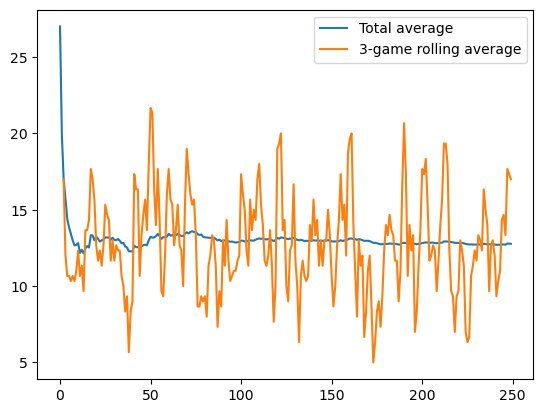

['Sullivan', 'Sirota', 'Crossen', 'Macgregor', 'Lane', 'Smith', 'Musacchia', 'Feinberg', 'Bozzo']
13.736 runs per game


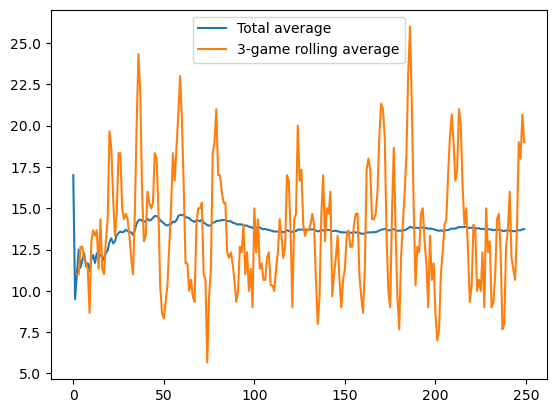

In [42]:
simulate_n_lineups([lineup_3, reece_lineup], [nu23]*2, pxp, n=250)

In [43]:
'''# Convert the list to a Pandas Series
runs_series = pd.Series(each_run)

# Compute the rolling average using a window of size 5
rolling_average = runs_series.rolling(window=3).mean()

# Plot the original data and the rolling average
plt.plot(runs_graph, label='Total average')
plt.plot(rolling_average, label='3-game rolling average')
plt.legend()
plt.show()
'''

"# Convert the list to a Pandas Series\nruns_series = pd.Series(each_run)\n\n# Compute the rolling average using a window of size 5\nrolling_average = runs_series.rolling(window=3).mean()\n\n# Plot the original data and the rolling average\nplt.plot(runs_graph, label='Total average')\nplt.plot(rolling_average, label='3-game rolling average')\nplt.legend()\nplt.show()\n"

## Indivual Pitchers

In [44]:
scotti = pxp.loc[(pxp['pitcher'] == 'Scotti') & (pxp['opponent'] == 'NE')].groupby(
    'pitchTypeFull').agg({'xRV':'mean','pitcher':'size'}).rename(columns = {'pitcher':'pitches'})
scotti = scotti.loc[scotti['pitches'] > 50]

X = scotti[['xRV']]

scotti['xOBP'] = model_obp.predict(X)

scotti['xOPS'] = model_ops.predict(X)

In [45]:
yost = pxp.loc[(pxp['pitcher'] == 'Yost') & (pxp['opponent'] == 'NE')].groupby(
    'pitchTypeFull').agg({'xRV':'mean','pitcher':'size'}).rename(columns = {'pitcher':'pitches'})
yost = scotti.loc[scotti['pitches'] > 50]

X = yost[['xRV']]

yost['xOBP'] = model_obp.predict(X)

yost['xOPS'] = model_ops.predict(X)

In [46]:
print('Scotti')
display(scotti)

print('Yost')
display(yost)

Scotti


,xRV,pitches,xOBP,xOPS
pitchTypeFull,,,,
Changeup,-0.023447,259,0.270431,0.485751
Fastball,0.001226,406,0.356230,0.750258
Slider,-0.016690,155,0.293930,0.558193


Yost


,xRV,pitches,xOBP,xOPS
pitchTypeFull,,,,
Changeup,-0.023447,259,0.270431,0.485751
Fastball,0.001226,406,0.356230,0.750258
Slider,-0.016690,155,0.293930,0.558193
